In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf #can specify in formula like format - requires dataframe as input
import statsmodels.api as sm #can take numpy arrays as well; easier to use predict function
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix #for calculating confusion matrix independently
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

### QUESTION 5

In [2]:
default = pd.read_csv('/home/harsh/Desktop/ISLR/dataset/Default.csv')
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [14]:
# (b)

X = default[['balance', 'income']].values
Y = default['default']

x_train, x_test, y_train, y_test = train_test_split(X, Y)

clf_lr = LogisticRegression(random_state=0).fit(x_train, y_train)

y_pred = clf_lr.predict(x_test) #for scikit's LR, .predict() uses 0.5 threshold; can also use .predict_proba()
error_rate = (1 - (y_pred==y_test).mean())*100
print ('Error rate for LR - ', error_rate)

Error rate for LR -  2.6000000000000023


In [16]:
# (c)

def LR_predict(a, b):
    x_train, x_test, y_train, y_test = train_test_split(a, b)
    
    clf_lr = LogisticRegression(random_state=0).fit(x_train, y_train)
    
    y_pred = clf_lr.predict(x_test)
    error_rate = (1 - (y_pred==y_test).mean())*100
    return (error_rate)

for i in range(3):
    err = LR_predict(X, Y)
    print ('iter - ', i+1, ':: Error - ', err)

iter -  1 :: Error -  3.0000000000000027
iter -  2 :: Error -  3.0000000000000027
iter -  3 :: Error -  3.1200000000000006


In [22]:
# (d)

df = default.copy()
df['student_yes'] = np.where(df['student'] == 'Yes', 1, 0)
df['default_yes'] = np.where(df['default'] == 'Yes', 1, 0)

X = df[['balance', 'income', 'student_yes']].values
Y = df['default']


for i in range(3):
    err = LR_predict(X, Y)
    print ('iter - ', i+1, ':: Error - ', err)

# Error rate doesn't improve after addition of student indicator

iter -  1 :: Error -  3.639999999999999
iter -  2 :: Error -  3.600000000000003
iter -  3 :: Error -  3.080000000000005


### QUESTION 6

In [24]:
# obtaining SE of the coefficients using the statsmodels package
# the summary of the results contains SE for the coefficients
results = smf.logit('default_yes ~ balance + income', data = df).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 21 Jan 2021   Pseudo R-squ.:                  0.4594
Time:                        12:39:45   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [25]:
#obtaining SE using bootstrap method
#using scikit's LR method, storing coefficients and then calculating std dev of the coefficients as the SE

params = np.zeros((100,2))
for i in range(100):
    temp_df = df.sample(frac=1, replace=True, random_state=1)
    X = df[['balance', 'income']].values
    Y = df['default']
    clf_lr = LogisticRegression(random_state=0).fit(X, Y)
    params[i,:] = clf_lr.coef_

In [27]:
print(np.std(params[:,0]))
print(np.std(params[:,1]))

#The SE calculated here using bootstrap and scikit's LR seems to be lower than the one calculated by smf above

8.673617379884035e-19
6.776263578034403e-21


### QUESTION 7

In [28]:
weekly = pd.read_csv('/home/harsh/Desktop/ISLR/dataset/Weekly.csv')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [54]:
n = len(weekly)
pred_results = np.ones(n)
for i in range(n):
    df = weekly.copy()
    df.drop(i, axis=0, inplace=True)
    df.reset_index(inplace=True)
    X = df[['Lag1', 'Lag2']].values
    Y = df['Direction']
    y_test = weekly['Direction'][i]
    x_test = weekly.iloc[i, 1:3].values.reshape(1,-1) #(-1,1) for (2,)>>(2,1) & (1,-1) for (2,) >> (1,2)
    clf_lr = LogisticRegression(random_state=0).fit(X, Y)
    y_pred = clf_lr.predict(x_test)
    if y_pred == y_test:
        pred_results[i] = 0

# Error in prediction = 490/1089 = 45%

### QUESTION 8

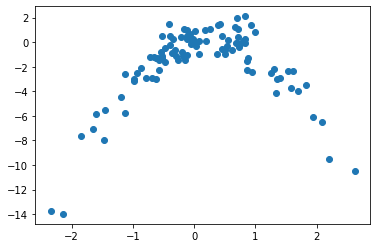

In [56]:
# (a), (b)
np.random.seed(9001)
x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)

# y = x - 2x^2 + eps -- n = 100 and p = 2

plt.scatter(x, y)

In [131]:
df = pd.DataFrame(data=np.column_stack((y, x, x**2, x**3, x**4)), columns=['y', 'x', 'x2', 'x3', 'x4'])

n = len(df)
pred_err = np.zeros((n,4))

for i in range(n):
    temp_df = df.copy()
    temp_df.drop(i, axis=0, inplace=True)
    temp_df.reset_index(inplace=True)
    
    y_test = df['y'][i]
    
    x_test = df['x'][[i]]
    results = smf.ols('y ~ x', data=temp_df).fit()
    y_pred = results.predict(x_test)
    pred_err[i,0] = y_test - y_pred
    
    x_test = df[['x', 'x2']].iloc[i]
    results = smf.ols('y ~ x + x2', data=temp_df).fit()
    y_pred = results.predict(x_test)
    pred_err[i,1] = y_test - y_pred
    
    x_test = df[['x', 'x2', 'x3']].iloc[i]
    results = smf.ols('y ~ x + x2 + x3', data=temp_df).fit()
    y_pred = results.predict(x_test)
    pred_err[i,2] = y_test - y_pred
    
    x_test = df[['x', 'x2', 'x3', 'x4']].iloc[i]
    results = smf.ols('y ~ x + x2 + x3 + x4', data=temp_df).fit()
    y_pred = results.predict(x_test)
    pred_err[i,3] = y_test - y_pred

In [132]:
np.mean(pred_err, axis=0)

# Quadratic had the lowest error as expected

array([-0.04177919,  0.0012296 ,  0.00716929,  0.0189655 ])

### QUESTION 9

In [133]:
boston = pd.read_csv('/home/harsh/Desktop/ISLR/dataset/Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [135]:
# (a)

print ('medv mean = ', boston['medv'].mean())

# (b)

print ('Std error of medv mean = ', boston['medv'].std()/len(boston)**0.5)

medv mean =  22.532806324110698
Std error of medv mean =  0.4088611474975351


In [143]:
# (c)

val = np.zeros((100,2))
for i in range(100):
    temp_df = boston.sample(frac=1, replace=True, random_state=1)
    val[i, 0] = temp_df['medv'].mean()
    val[i, 1] = temp_df['medv'].std()/len(temp_df) #SE

bootstrap_val = np.nanmean(val, axis=0)
print(bootstrap_val)

# SE using bootstrap is lower

# (d)
intv1 = bootstrap_val[0] - 2*bootstrap_val[1]
intv2 = bootstrap_val[0] + 2*bootstrap_val[1]
print ('95% confidence interval - ', intv1, intv2 )

[2.18806324e+01 1.75011849e-02]
95% confidence interval -  21.845630041178072 21.91563478095627


In [144]:
# (e, f)

print('medv median', boston['medv'].median())

val = np.zeros((100,2))
for i in range(100):
    temp_df = boston.sample(frac=1, replace=True, random_state=1)
    val[i, 0] = temp_df['medv'].median()
    val[i, 1] = temp_df['medv'].std()/len(temp_df) #SE

bootstrap_val = np.nanmean(val, axis=0)
print(bootstrap_val)

# SE using bootstrap is lower

# (d)
intv1 = bootstrap_val[0] - 2*bootstrap_val[1]
intv2 = bootstrap_val[0] + 2*bootstrap_val[1]
print ('95% confidence interval - ', intv1, intv2 )


medv median 21.2
[2.06000000e+01 1.75011849e-02]
95% confidence interval -  20.564997630110863 20.63500236988906
